## Access Vessel TRV Realtime Qc (Parquet)

This Jupyter notebook demonstrates how to access and plot vessel trv realtime qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/8af21108-c535-43bf-8dab-c1f45a26088c).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_trv_realtime_qc.ipynb).


In [1]:
dataset_name = "vessel_trv_realtime_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 55ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 177 ms, sys: 37.3 ms, total: 214 ms
Wall time: 7.32 s


In [5]:
aodn_dataset.dataset.partitioning.schema

platform_code: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('platform_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['VNCF', 'VMQ9273']
CPU times: user 21.7 ms, sys: 4.93 ms, total: 26.7 ms
Wall time: 23.2 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


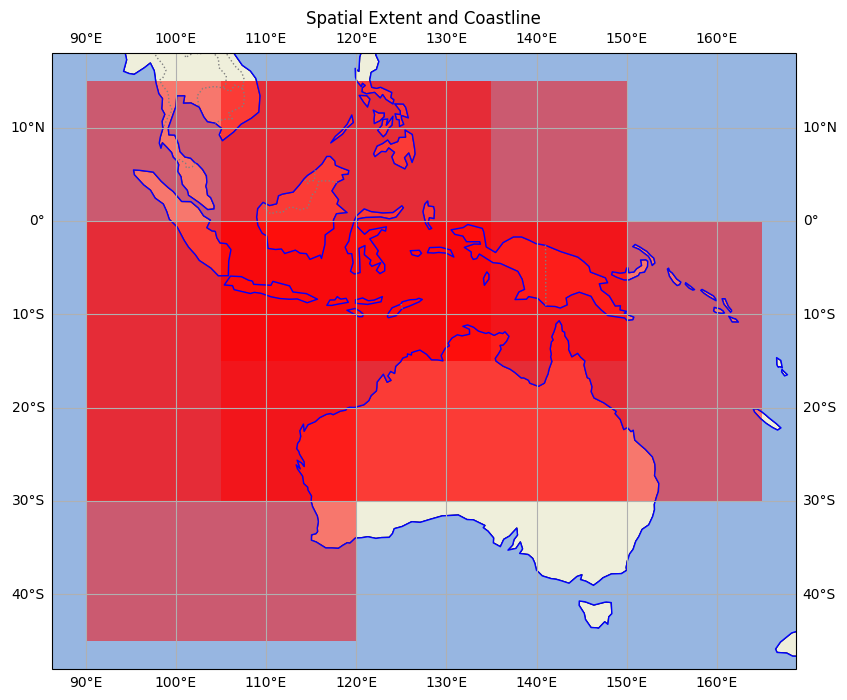

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2008-09-30 00:27:27'), Timestamp('2022-10-09 20:55:57'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:28:29,043 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_trv_realtime_qc.parquet
2025-06-05 13:28:29,170 - aodn.GetAodn - WARNING - Old 'dataset_metadata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'platform_code': {'type': 'string'},
 'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'LATITUDE_quality_control': {'type': 'double',
  'long_name': 'LATITUDE quality control',
  'standard_name': 'latitude status_flag',
  'quality_control_conventions': 'IMOS standard set using the IODE flags',
  'valid_min': 0.0,
  'valid_max': 9.0,
  'flag_values': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
  'flag_meanings': 'no_qc_performed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed not_used not_used interpolated_values missing_values'},
 'LATITUDE': {'type': 'double',
  'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'geographical coordinates, WGS84 projection',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE_quality_control': {'type': 'double',
  'long_name':

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2010-01-01 10:14:00', date_end='2010-03-01 07:50:00',lat_min=-23, lat_max=-20, lon_min=150, lon_max=155)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800906 entries, 0 to 800905
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   filename                   800906 non-null  object        
 1   LATITUDE_quality_control   800906 non-null  float64       
 2   LATITUDE                   800906 non-null  float64       
 3   LONGITUDE_quality_control  800906 non-null  float64       
 4   LONGITUDE                  800906 non-null  float64       
 5   DEPTH                      800906 non-null  float64       
 6   CPHL                       211652 non-null  float64       
 7   CPHL_quality_control       211652 non-null  float64       
 8   TIME                       800906 non-null  datetime64[ns]
 9   TURB                       210179 non-null  float32       
 10  TURB_quality_control       210179 non-null  float32       
 11  TEMP                       212770 non-null  float32 

In [ ]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

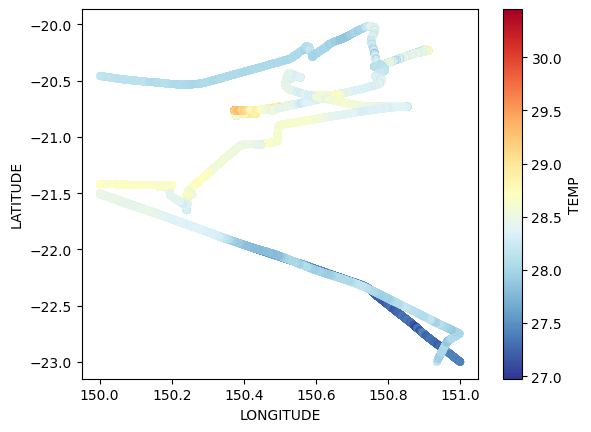

In [11]:
df.plot.scatter(x="LONGITUDE", y='LATITUDE', c="TEMP", cmap='RdYlBu_r')

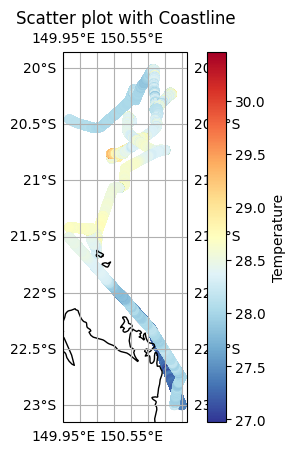

In [12]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

norm = Normalize(vmin=df['TEMP'].min(), vmax=df['TEMP'].max())

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df["TEMP"], cmap='RdYlBu_r', norm=norm, transform=ccrs.PlateCarree())

# Add a coastline
ax.coastlines()

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Temperature')

ax.gridlines(draw_labels=True)
ax.set_title('Scatter plot with Coastline')
plt.show()

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [13]:
%%time
df = aodn_dataset.get_data(date_start='2010-01-31 10:14:00', date_end='2010-02-01 07:50:00',
                          scalar_filter = {'platform_code': 'VNCF'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11038 entries, 0 to 11037
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   filename                   11038 non-null  object        
 1   LATITUDE_quality_control   11038 non-null  float64       
 2   LATITUDE                   11038 non-null  float64       
 3   LONGITUDE_quality_control  11038 non-null  float64       
 4   LONGITUDE                  11038 non-null  float64       
 5   DEPTH                      11038 non-null  float64       
 6   CPHL                       3931 non-null   float64       
 7   CPHL_quality_control       3931 non-null   float64       
 8   TIME                       11038 non-null  datetime64[ns]
 9   TURB                       3091 non-null   float32       
 10  TURB_quality_control       3091 non-null   float32       
 11  TEMP                       3953 non-null   float32       
 12  TEMP

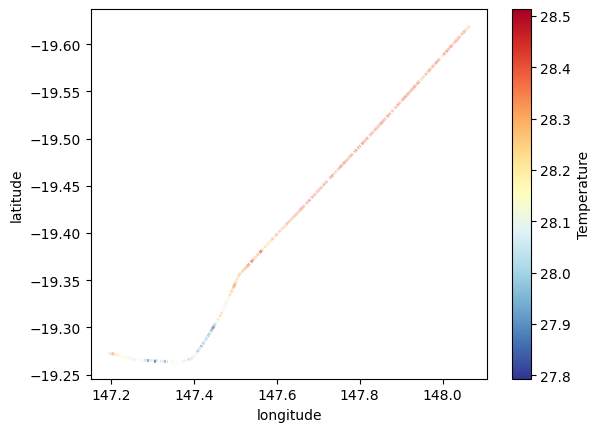

In [14]:
import numpy as np 
from matplotlib.collections import LineCollection

df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()